In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import qai_hub as hub
from fast_scnn import FastSCNN  # make sure this is in your Python path

# -----------------------------------------------------------------------------
# 1) Convert BatchNorm → GroupNorm (to match your fine-tuned weights)
# -----------------------------------------------------------------------------
def convert_bn_to_gn(module: nn.Module, num_groups: int = 8):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            gn = nn.GroupNorm(
                num_groups=num_groups,
                num_channels=child.num_features,
                affine=True
            )
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, num_groups)

# -----------------------------------------------------------------------------
# 2) Load and prepare your FastSCNN model
# -----------------------------------------------------------------------------
torch_model = FastSCNN(num_classes=2, aux=False)
# convert_bn_to_gn(torch_model, num_groups=8)
# ckpt = torch.load("best_fastscnn_epoch770.pth", map_location="cpu")
# ckpt = torch.load("best_fastscnn_epoch1200.pth", map_location="cpu")
# ckpt = torch.load("best_fastscnn_epoch1780.pth", map_location="cpu")
# ckpt = torch.load("best_fastscnn_epoch2140.pth", map_location="cpu")
ckpt = torch.load("best_fastscnn_epoch1420.pth", map_location="cpu")
# raw_ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")
# ckpt = {k.replace("module.", ""): v for k, v in raw_ckpt.items()}

torch_model.load_state_dict(ckpt)
torch_model.eval()

# -----------------------------------------------------------------------------
# 3) Trace the model using standard NCHW input
# -----------------------------------------------------------------------------
INPUT_SHAPE = (1, 3, 576, 576)
example = torch.rand(INPUT_SHAPE, dtype=torch.float32)
traced_model = torch.jit.trace(torch_model, example, strict=False)

# -----------------------------------------------------------------------------
# 4) Compile to ONNX using QAI Hub
# -----------------------------------------------------------------------------
device = hub.Device("QCS8550 (Proxy)")
compile_job = hub.submit_compile_job(
    model=traced_model,
    device=device,
    input_specs={"input": INPUT_SHAPE},  # 'input' matches torch_model.forward(input)
    options="--target_runtime onnx"
)
onnx_model = compile_job.get_target_model()
print("✅ ONNX compile complete")

# -----------------------------------------------------------------------------
# 5) Load calibration data from directory
# -----------------------------------------------------------------------------
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 3, 1, 1)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 3, 1, 1)

calib_dir = "IMG_cracks" # modify if needed
# calib_dir = "imagenette_samples_2/images"
samples = []

for fname in sorted(os.listdir(calib_dir)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img = Image.open(os.path.join(calib_dir, fname)).convert("RGB")
    img = img.resize((576, 576), Image.LANCZOS)
    arr = np.array(img, dtype=np.float32) / 255.0

    # Convert to NCHW + normalize
    arr = arr.transpose(2, 0, 1)[np.newaxis, ...]  # (HWC → CHW → NCHW)
    arr = (arr - mean) / std
    arr = arr.reshape((1, 3, 576, 576))
    samples.append(arr)

    if len(samples) >= 109:
        break

calib_dir = "imagenette_samples_2/images"
for fname in sorted(os.listdir(calib_dir)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img = Image.open(os.path.join(calib_dir, fname)).convert("RGB")
    img = img.resize((576, 576), Image.LANCZOS)
    arr = np.array(img, dtype=np.float32) / 255.0

    # Convert to NCHW + normalize
    arr = arr.transpose(2, 0, 1)[np.newaxis, ...]  # (HWC → CHW → NCHW)
    arr = (arr - mean) / std
    arr = arr.reshape((1, 3, 576, 576))
    samples.append(arr)

    if len(samples) >= 550:
        break

print(f"✅ Found {len(samples)} calibration images")
if len(samples) == 0:
    raise RuntimeError(f"No calibration images found in {calib_dir}")

calibration_data = {"input": samples}




/tmp/ipykernel_3522881/1933458877.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_fastscnn_epoch1420.pth", map_location="cpu")


RuntimeError: Error(s) in loading state_dict for FastSCNN:
	Missing key(s) in state_dict: "learning_to_downsample.conv.conv.0.weight", "learning_to_downsample.conv.conv.1.weight", "learning_to_downsample.conv.conv.1.bias", "learning_to_downsample.conv.conv.1.running_mean", "learning_to_downsample.conv.conv.1.running_var", "learning_to_downsample.dsconv1.conv.0.weight", "learning_to_downsample.dsconv1.conv.1.weight", "learning_to_downsample.dsconv1.conv.1.bias", "learning_to_downsample.dsconv1.conv.1.running_mean", "learning_to_downsample.dsconv1.conv.1.running_var", "learning_to_downsample.dsconv1.conv.3.weight", "learning_to_downsample.dsconv1.conv.4.weight", "learning_to_downsample.dsconv1.conv.4.bias", "learning_to_downsample.dsconv1.conv.4.running_mean", "learning_to_downsample.dsconv1.conv.4.running_var", "learning_to_downsample.dsconv2.conv.0.weight", "learning_to_downsample.dsconv2.conv.1.weight", "learning_to_downsample.dsconv2.conv.1.bias", "learning_to_downsample.dsconv2.conv.1.running_mean", "learning_to_downsample.dsconv2.conv.1.running_var", "learning_to_downsample.dsconv2.conv.3.weight", "learning_to_downsample.dsconv2.conv.4.weight", "learning_to_downsample.dsconv2.conv.4.bias", "learning_to_downsample.dsconv2.conv.4.running_mean", "learning_to_downsample.dsconv2.conv.4.running_var", "global_feature_extractor.bottleneck1.0.block.0.conv.0.weight", "global_feature_extractor.bottleneck1.0.block.0.conv.1.weight", "global_feature_extractor.bottleneck1.0.block.0.conv.1.bias", "global_feature_extractor.bottleneck1.0.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck1.0.block.0.conv.1.running_var", "global_feature_extractor.bottleneck1.0.block.1.conv.0.weight", "global_feature_extractor.bottleneck1.0.block.1.conv.1.weight", "global_feature_extractor.bottleneck1.0.block.1.conv.1.bias", "global_feature_extractor.bottleneck1.0.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck1.0.block.1.conv.1.running_var", "global_feature_extractor.bottleneck1.0.block.2.weight", "global_feature_extractor.bottleneck1.0.block.3.weight", "global_feature_extractor.bottleneck1.0.block.3.bias", "global_feature_extractor.bottleneck1.0.block.3.running_mean", "global_feature_extractor.bottleneck1.0.block.3.running_var", "global_feature_extractor.bottleneck1.1.block.0.conv.0.weight", "global_feature_extractor.bottleneck1.1.block.0.conv.1.weight", "global_feature_extractor.bottleneck1.1.block.0.conv.1.bias", "global_feature_extractor.bottleneck1.1.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck1.1.block.0.conv.1.running_var", "global_feature_extractor.bottleneck1.1.block.1.conv.0.weight", "global_feature_extractor.bottleneck1.1.block.1.conv.1.weight", "global_feature_extractor.bottleneck1.1.block.1.conv.1.bias", "global_feature_extractor.bottleneck1.1.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck1.1.block.1.conv.1.running_var", "global_feature_extractor.bottleneck1.1.block.2.weight", "global_feature_extractor.bottleneck1.1.block.3.weight", "global_feature_extractor.bottleneck1.1.block.3.bias", "global_feature_extractor.bottleneck1.1.block.3.running_mean", "global_feature_extractor.bottleneck1.1.block.3.running_var", "global_feature_extractor.bottleneck1.2.block.0.conv.0.weight", "global_feature_extractor.bottleneck1.2.block.0.conv.1.weight", "global_feature_extractor.bottleneck1.2.block.0.conv.1.bias", "global_feature_extractor.bottleneck1.2.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck1.2.block.0.conv.1.running_var", "global_feature_extractor.bottleneck1.2.block.1.conv.0.weight", "global_feature_extractor.bottleneck1.2.block.1.conv.1.weight", "global_feature_extractor.bottleneck1.2.block.1.conv.1.bias", "global_feature_extractor.bottleneck1.2.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck1.2.block.1.conv.1.running_var", "global_feature_extractor.bottleneck1.2.block.2.weight", "global_feature_extractor.bottleneck1.2.block.3.weight", "global_feature_extractor.bottleneck1.2.block.3.bias", "global_feature_extractor.bottleneck1.2.block.3.running_mean", "global_feature_extractor.bottleneck1.2.block.3.running_var", "global_feature_extractor.bottleneck2.0.block.0.conv.0.weight", "global_feature_extractor.bottleneck2.0.block.0.conv.1.weight", "global_feature_extractor.bottleneck2.0.block.0.conv.1.bias", "global_feature_extractor.bottleneck2.0.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck2.0.block.0.conv.1.running_var", "global_feature_extractor.bottleneck2.0.block.1.conv.0.weight", "global_feature_extractor.bottleneck2.0.block.1.conv.1.weight", "global_feature_extractor.bottleneck2.0.block.1.conv.1.bias", "global_feature_extractor.bottleneck2.0.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck2.0.block.1.conv.1.running_var", "global_feature_extractor.bottleneck2.0.block.2.weight", "global_feature_extractor.bottleneck2.0.block.3.weight", "global_feature_extractor.bottleneck2.0.block.3.bias", "global_feature_extractor.bottleneck2.0.block.3.running_mean", "global_feature_extractor.bottleneck2.0.block.3.running_var", "global_feature_extractor.bottleneck2.1.block.0.conv.0.weight", "global_feature_extractor.bottleneck2.1.block.0.conv.1.weight", "global_feature_extractor.bottleneck2.1.block.0.conv.1.bias", "global_feature_extractor.bottleneck2.1.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck2.1.block.0.conv.1.running_var", "global_feature_extractor.bottleneck2.1.block.1.conv.0.weight", "global_feature_extractor.bottleneck2.1.block.1.conv.1.weight", "global_feature_extractor.bottleneck2.1.block.1.conv.1.bias", "global_feature_extractor.bottleneck2.1.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck2.1.block.1.conv.1.running_var", "global_feature_extractor.bottleneck2.1.block.2.weight", "global_feature_extractor.bottleneck2.1.block.3.weight", "global_feature_extractor.bottleneck2.1.block.3.bias", "global_feature_extractor.bottleneck2.1.block.3.running_mean", "global_feature_extractor.bottleneck2.1.block.3.running_var", "global_feature_extractor.bottleneck2.2.block.0.conv.0.weight", "global_feature_extractor.bottleneck2.2.block.0.conv.1.weight", "global_feature_extractor.bottleneck2.2.block.0.conv.1.bias", "global_feature_extractor.bottleneck2.2.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck2.2.block.0.conv.1.running_var", "global_feature_extractor.bottleneck2.2.block.1.conv.0.weight", "global_feature_extractor.bottleneck2.2.block.1.conv.1.weight", "global_feature_extractor.bottleneck2.2.block.1.conv.1.bias", "global_feature_extractor.bottleneck2.2.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck2.2.block.1.conv.1.running_var", "global_feature_extractor.bottleneck2.2.block.2.weight", "global_feature_extractor.bottleneck2.2.block.3.weight", "global_feature_extractor.bottleneck2.2.block.3.bias", "global_feature_extractor.bottleneck2.2.block.3.running_mean", "global_feature_extractor.bottleneck2.2.block.3.running_var", "global_feature_extractor.bottleneck3.0.block.0.conv.0.weight", "global_feature_extractor.bottleneck3.0.block.0.conv.1.weight", "global_feature_extractor.bottleneck3.0.block.0.conv.1.bias", "global_feature_extractor.bottleneck3.0.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck3.0.block.0.conv.1.running_var", "global_feature_extractor.bottleneck3.0.block.1.conv.0.weight", "global_feature_extractor.bottleneck3.0.block.1.conv.1.weight", "global_feature_extractor.bottleneck3.0.block.1.conv.1.bias", "global_feature_extractor.bottleneck3.0.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck3.0.block.1.conv.1.running_var", "global_feature_extractor.bottleneck3.0.block.2.weight", "global_feature_extractor.bottleneck3.0.block.3.weight", "global_feature_extractor.bottleneck3.0.block.3.bias", "global_feature_extractor.bottleneck3.0.block.3.running_mean", "global_feature_extractor.bottleneck3.0.block.3.running_var", "global_feature_extractor.bottleneck3.1.block.0.conv.0.weight", "global_feature_extractor.bottleneck3.1.block.0.conv.1.weight", "global_feature_extractor.bottleneck3.1.block.0.conv.1.bias", "global_feature_extractor.bottleneck3.1.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck3.1.block.0.conv.1.running_var", "global_feature_extractor.bottleneck3.1.block.1.conv.0.weight", "global_feature_extractor.bottleneck3.1.block.1.conv.1.weight", "global_feature_extractor.bottleneck3.1.block.1.conv.1.bias", "global_feature_extractor.bottleneck3.1.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck3.1.block.1.conv.1.running_var", "global_feature_extractor.bottleneck3.1.block.2.weight", "global_feature_extractor.bottleneck3.1.block.3.weight", "global_feature_extractor.bottleneck3.1.block.3.bias", "global_feature_extractor.bottleneck3.1.block.3.running_mean", "global_feature_extractor.bottleneck3.1.block.3.running_var", "global_feature_extractor.bottleneck3.2.block.0.conv.0.weight", "global_feature_extractor.bottleneck3.2.block.0.conv.1.weight", "global_feature_extractor.bottleneck3.2.block.0.conv.1.bias", "global_feature_extractor.bottleneck3.2.block.0.conv.1.running_mean", "global_feature_extractor.bottleneck3.2.block.0.conv.1.running_var", "global_feature_extractor.bottleneck3.2.block.1.conv.0.weight", "global_feature_extractor.bottleneck3.2.block.1.conv.1.weight", "global_feature_extractor.bottleneck3.2.block.1.conv.1.bias", "global_feature_extractor.bottleneck3.2.block.1.conv.1.running_mean", "global_feature_extractor.bottleneck3.2.block.1.conv.1.running_var", "global_feature_extractor.bottleneck3.2.block.2.weight", "global_feature_extractor.bottleneck3.2.block.3.weight", "global_feature_extractor.bottleneck3.2.block.3.bias", "global_feature_extractor.bottleneck3.2.block.3.running_mean", "global_feature_extractor.bottleneck3.2.block.3.running_var", "global_feature_extractor.ppm.conv1.conv.0.weight", "global_feature_extractor.ppm.conv1.conv.1.weight", "global_feature_extractor.ppm.conv1.conv.1.bias", "global_feature_extractor.ppm.conv1.conv.1.running_mean", "global_feature_extractor.ppm.conv1.conv.1.running_var", "global_feature_extractor.ppm.conv2.conv.0.weight", "global_feature_extractor.ppm.conv2.conv.1.weight", "global_feature_extractor.ppm.conv2.conv.1.bias", "global_feature_extractor.ppm.conv2.conv.1.running_mean", "global_feature_extractor.ppm.conv2.conv.1.running_var", "global_feature_extractor.ppm.conv3.conv.0.weight", "global_feature_extractor.ppm.conv3.conv.1.weight", "global_feature_extractor.ppm.conv3.conv.1.bias", "global_feature_extractor.ppm.conv3.conv.1.running_mean", "global_feature_extractor.ppm.conv3.conv.1.running_var", "global_feature_extractor.ppm.conv4.conv.0.weight", "global_feature_extractor.ppm.conv4.conv.1.weight", "global_feature_extractor.ppm.conv4.conv.1.bias", "global_feature_extractor.ppm.conv4.conv.1.running_mean", "global_feature_extractor.ppm.conv4.conv.1.running_var", "global_feature_extractor.ppm.out.conv.0.weight", "global_feature_extractor.ppm.out.conv.1.weight", "global_feature_extractor.ppm.out.conv.1.bias", "global_feature_extractor.ppm.out.conv.1.running_mean", "global_feature_extractor.ppm.out.conv.1.running_var", "feature_fusion.dwconv.conv.0.weight", "feature_fusion.dwconv.conv.1.weight", "feature_fusion.dwconv.conv.1.bias", "feature_fusion.dwconv.conv.1.running_mean", "feature_fusion.dwconv.conv.1.running_var", "feature_fusion.conv_lower_res.0.weight", "feature_fusion.conv_lower_res.0.bias", "feature_fusion.conv_lower_res.1.weight", "feature_fusion.conv_lower_res.1.bias", "feature_fusion.conv_lower_res.1.running_mean", "feature_fusion.conv_lower_res.1.running_var", "feature_fusion.conv_higher_res.0.weight", "feature_fusion.conv_higher_res.0.bias", "feature_fusion.conv_higher_res.1.weight", "feature_fusion.conv_higher_res.1.bias", "feature_fusion.conv_higher_res.1.running_mean", "feature_fusion.conv_higher_res.1.running_var", "classifier.dsconv1.conv.0.weight", "classifier.dsconv1.conv.1.weight", "classifier.dsconv1.conv.1.bias", "classifier.dsconv1.conv.1.running_mean", "classifier.dsconv1.conv.1.running_var", "classifier.dsconv1.conv.3.weight", "classifier.dsconv1.conv.4.weight", "classifier.dsconv1.conv.4.bias", "classifier.dsconv1.conv.4.running_mean", "classifier.dsconv1.conv.4.running_var", "classifier.dsconv2.conv.0.weight", "classifier.dsconv2.conv.1.weight", "classifier.dsconv2.conv.1.bias", "classifier.dsconv2.conv.1.running_mean", "classifier.dsconv2.conv.1.running_var", "classifier.dsconv2.conv.3.weight", "classifier.dsconv2.conv.4.weight", "classifier.dsconv2.conv.4.bias", "classifier.dsconv2.conv.4.running_mean", "classifier.dsconv2.conv.4.running_var", "classifier.conv.1.weight", "classifier.conv.1.bias". 
	Unexpected key(s) in state_dict: "module.learning_to_downsample.conv.conv.0.weight", "module.learning_to_downsample.conv.conv.1.weight", "module.learning_to_downsample.conv.conv.1.bias", "module.learning_to_downsample.conv.conv.1.running_mean", "module.learning_to_downsample.conv.conv.1.running_var", "module.learning_to_downsample.conv.conv.1.num_batches_tracked", "module.learning_to_downsample.dsconv1.conv.0.weight", "module.learning_to_downsample.dsconv1.conv.1.weight", "module.learning_to_downsample.dsconv1.conv.1.bias", "module.learning_to_downsample.dsconv1.conv.1.running_mean", "module.learning_to_downsample.dsconv1.conv.1.running_var", "module.learning_to_downsample.dsconv1.conv.1.num_batches_tracked", "module.learning_to_downsample.dsconv1.conv.3.weight", "module.learning_to_downsample.dsconv1.conv.4.weight", "module.learning_to_downsample.dsconv1.conv.4.bias", "module.learning_to_downsample.dsconv1.conv.4.running_mean", "module.learning_to_downsample.dsconv1.conv.4.running_var", "module.learning_to_downsample.dsconv1.conv.4.num_batches_tracked", "module.learning_to_downsample.dsconv2.conv.0.weight", "module.learning_to_downsample.dsconv2.conv.1.weight", "module.learning_to_downsample.dsconv2.conv.1.bias", "module.learning_to_downsample.dsconv2.conv.1.running_mean", "module.learning_to_downsample.dsconv2.conv.1.running_var", "module.learning_to_downsample.dsconv2.conv.1.num_batches_tracked", "module.learning_to_downsample.dsconv2.conv.3.weight", "module.learning_to_downsample.dsconv2.conv.4.weight", "module.learning_to_downsample.dsconv2.conv.4.bias", "module.learning_to_downsample.dsconv2.conv.4.running_mean", "module.learning_to_downsample.dsconv2.conv.4.running_var", "module.learning_to_downsample.dsconv2.conv.4.num_batches_tracked", "module.global_feature_extractor.bottleneck1.0.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck1.0.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck1.0.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck1.0.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.0.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck1.0.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.0.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck1.0.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck1.0.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck1.0.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.0.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck1.0.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.0.block.2.weight", "module.global_feature_extractor.bottleneck1.0.block.3.weight", "module.global_feature_extractor.bottleneck1.0.block.3.bias", "module.global_feature_extractor.bottleneck1.0.block.3.running_mean", "module.global_feature_extractor.bottleneck1.0.block.3.running_var", "module.global_feature_extractor.bottleneck1.0.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck1.1.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck1.1.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck1.1.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck1.1.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.1.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck1.1.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.1.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck1.1.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck1.1.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck1.1.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.1.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck1.1.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.1.block.2.weight", "module.global_feature_extractor.bottleneck1.1.block.3.weight", "module.global_feature_extractor.bottleneck1.1.block.3.bias", "module.global_feature_extractor.bottleneck1.1.block.3.running_mean", "module.global_feature_extractor.bottleneck1.1.block.3.running_var", "module.global_feature_extractor.bottleneck1.1.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck1.2.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck1.2.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck1.2.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck1.2.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.2.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck1.2.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.2.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck1.2.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck1.2.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck1.2.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck1.2.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck1.2.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck1.2.block.2.weight", "module.global_feature_extractor.bottleneck1.2.block.3.weight", "module.global_feature_extractor.bottleneck1.2.block.3.bias", "module.global_feature_extractor.bottleneck1.2.block.3.running_mean", "module.global_feature_extractor.bottleneck1.2.block.3.running_var", "module.global_feature_extractor.bottleneck1.2.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck2.0.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck2.0.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck2.0.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck2.0.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.0.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck2.0.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.0.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck2.0.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck2.0.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck2.0.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.0.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck2.0.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.0.block.2.weight", "module.global_feature_extractor.bottleneck2.0.block.3.weight", "module.global_feature_extractor.bottleneck2.0.block.3.bias", "module.global_feature_extractor.bottleneck2.0.block.3.running_mean", "module.global_feature_extractor.bottleneck2.0.block.3.running_var", "module.global_feature_extractor.bottleneck2.0.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck2.1.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck2.1.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck2.1.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck2.1.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.1.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck2.1.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.1.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck2.1.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck2.1.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck2.1.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.1.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck2.1.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.1.block.2.weight", "module.global_feature_extractor.bottleneck2.1.block.3.weight", "module.global_feature_extractor.bottleneck2.1.block.3.bias", "module.global_feature_extractor.bottleneck2.1.block.3.running_mean", "module.global_feature_extractor.bottleneck2.1.block.3.running_var", "module.global_feature_extractor.bottleneck2.1.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck2.2.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck2.2.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck2.2.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck2.2.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.2.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck2.2.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.2.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck2.2.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck2.2.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck2.2.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck2.2.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck2.2.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck2.2.block.2.weight", "module.global_feature_extractor.bottleneck2.2.block.3.weight", "module.global_feature_extractor.bottleneck2.2.block.3.bias", "module.global_feature_extractor.bottleneck2.2.block.3.running_mean", "module.global_feature_extractor.bottleneck2.2.block.3.running_var", "module.global_feature_extractor.bottleneck2.2.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck3.0.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck3.0.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck3.0.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck3.0.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.0.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck3.0.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.0.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck3.0.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck3.0.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck3.0.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.0.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck3.0.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.0.block.2.weight", "module.global_feature_extractor.bottleneck3.0.block.3.weight", "module.global_feature_extractor.bottleneck3.0.block.3.bias", "module.global_feature_extractor.bottleneck3.0.block.3.running_mean", "module.global_feature_extractor.bottleneck3.0.block.3.running_var", "module.global_feature_extractor.bottleneck3.0.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck3.1.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck3.1.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck3.1.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck3.1.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.1.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck3.1.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.1.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck3.1.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck3.1.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck3.1.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.1.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck3.1.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.1.block.2.weight", "module.global_feature_extractor.bottleneck3.1.block.3.weight", "module.global_feature_extractor.bottleneck3.1.block.3.bias", "module.global_feature_extractor.bottleneck3.1.block.3.running_mean", "module.global_feature_extractor.bottleneck3.1.block.3.running_var", "module.global_feature_extractor.bottleneck3.1.block.3.num_batches_tracked", "module.global_feature_extractor.bottleneck3.2.block.0.conv.0.weight", "module.global_feature_extractor.bottleneck3.2.block.0.conv.1.weight", "module.global_feature_extractor.bottleneck3.2.block.0.conv.1.bias", "module.global_feature_extractor.bottleneck3.2.block.0.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.2.block.0.conv.1.running_var", "module.global_feature_extractor.bottleneck3.2.block.0.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.2.block.1.conv.0.weight", "module.global_feature_extractor.bottleneck3.2.block.1.conv.1.weight", "module.global_feature_extractor.bottleneck3.2.block.1.conv.1.bias", "module.global_feature_extractor.bottleneck3.2.block.1.conv.1.running_mean", "module.global_feature_extractor.bottleneck3.2.block.1.conv.1.running_var", "module.global_feature_extractor.bottleneck3.2.block.1.conv.1.num_batches_tracked", "module.global_feature_extractor.bottleneck3.2.block.2.weight", "module.global_feature_extractor.bottleneck3.2.block.3.weight", "module.global_feature_extractor.bottleneck3.2.block.3.bias", "module.global_feature_extractor.bottleneck3.2.block.3.running_mean", "module.global_feature_extractor.bottleneck3.2.block.3.running_var", "module.global_feature_extractor.bottleneck3.2.block.3.num_batches_tracked", "module.global_feature_extractor.ppm.conv1.conv.0.weight", "module.global_feature_extractor.ppm.conv1.conv.1.weight", "module.global_feature_extractor.ppm.conv1.conv.1.bias", "module.global_feature_extractor.ppm.conv1.conv.1.running_mean", "module.global_feature_extractor.ppm.conv1.conv.1.running_var", "module.global_feature_extractor.ppm.conv1.conv.1.num_batches_tracked", "module.global_feature_extractor.ppm.conv2.conv.0.weight", "module.global_feature_extractor.ppm.conv2.conv.1.weight", "module.global_feature_extractor.ppm.conv2.conv.1.bias", "module.global_feature_extractor.ppm.conv2.conv.1.running_mean", "module.global_feature_extractor.ppm.conv2.conv.1.running_var", "module.global_feature_extractor.ppm.conv2.conv.1.num_batches_tracked", "module.global_feature_extractor.ppm.conv3.conv.0.weight", "module.global_feature_extractor.ppm.conv3.conv.1.weight", "module.global_feature_extractor.ppm.conv3.conv.1.bias", "module.global_feature_extractor.ppm.conv3.conv.1.running_mean", "module.global_feature_extractor.ppm.conv3.conv.1.running_var", "module.global_feature_extractor.ppm.conv3.conv.1.num_batches_tracked", "module.global_feature_extractor.ppm.conv4.conv.0.weight", "module.global_feature_extractor.ppm.conv4.conv.1.weight", "module.global_feature_extractor.ppm.conv4.conv.1.bias", "module.global_feature_extractor.ppm.conv4.conv.1.running_mean", "module.global_feature_extractor.ppm.conv4.conv.1.running_var", "module.global_feature_extractor.ppm.conv4.conv.1.num_batches_tracked", "module.global_feature_extractor.ppm.out.conv.0.weight", "module.global_feature_extractor.ppm.out.conv.1.weight", "module.global_feature_extractor.ppm.out.conv.1.bias", "module.global_feature_extractor.ppm.out.conv.1.running_mean", "module.global_feature_extractor.ppm.out.conv.1.running_var", "module.global_feature_extractor.ppm.out.conv.1.num_batches_tracked", "module.feature_fusion.dwconv.conv.0.weight", "module.feature_fusion.dwconv.conv.1.weight", "module.feature_fusion.dwconv.conv.1.bias", "module.feature_fusion.dwconv.conv.1.running_mean", "module.feature_fusion.dwconv.conv.1.running_var", "module.feature_fusion.dwconv.conv.1.num_batches_tracked", "module.feature_fusion.conv_lower_res.0.weight", "module.feature_fusion.conv_lower_res.0.bias", "module.feature_fusion.conv_lower_res.1.weight", "module.feature_fusion.conv_lower_res.1.bias", "module.feature_fusion.conv_lower_res.1.running_mean", "module.feature_fusion.conv_lower_res.1.running_var", "module.feature_fusion.conv_lower_res.1.num_batches_tracked", "module.feature_fusion.conv_higher_res.0.weight", "module.feature_fusion.conv_higher_res.0.bias", "module.feature_fusion.conv_higher_res.1.weight", "module.feature_fusion.conv_higher_res.1.bias", "module.feature_fusion.conv_higher_res.1.running_mean", "module.feature_fusion.conv_higher_res.1.running_var", "module.feature_fusion.conv_higher_res.1.num_batches_tracked", "module.classifier.dsconv1.conv.0.weight", "module.classifier.dsconv1.conv.1.weight", "module.classifier.dsconv1.conv.1.bias", "module.classifier.dsconv1.conv.1.running_mean", "module.classifier.dsconv1.conv.1.running_var", "module.classifier.dsconv1.conv.1.num_batches_tracked", "module.classifier.dsconv1.conv.3.weight", "module.classifier.dsconv1.conv.4.weight", "module.classifier.dsconv1.conv.4.bias", "module.classifier.dsconv1.conv.4.running_mean", "module.classifier.dsconv1.conv.4.running_var", "module.classifier.dsconv1.conv.4.num_batches_tracked", "module.classifier.dsconv2.conv.0.weight", "module.classifier.dsconv2.conv.1.weight", "module.classifier.dsconv2.conv.1.bias", "module.classifier.dsconv2.conv.1.running_mean", "module.classifier.dsconv2.conv.1.running_var", "module.classifier.dsconv2.conv.1.num_batches_tracked", "module.classifier.dsconv2.conv.3.weight", "module.classifier.dsconv2.conv.4.weight", "module.classifier.dsconv2.conv.4.bias", "module.classifier.dsconv2.conv.4.running_mean", "module.classifier.dsconv2.conv.4.running_var", "module.classifier.dsconv2.conv.4.num_batches_tracked", "module.classifier.conv.1.weight", "module.classifier.conv.1.bias". 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import qai_hub as hub
from fast_scnn import FastSCNN  # make sure this is in your Python path

# -----------------------------------------------------------------------------
# 1) Convert BatchNorm → GroupNorm (to match your fine-tuned weights)
# -----------------------------------------------------------------------------
def convert_bn_to_gn(module: nn.Module, num_groups: int = 8):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            gn = nn.GroupNorm(
                num_groups=num_groups,
                num_channels=child.num_features,
                affine=True
            )
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, num_groups)

# -----------------------------------------------------------------------------
# 2) Load and prepare your FastSCNN model  (FIXED)
# -----------------------------------------------------------------------------
torch_model = FastSCNN(num_classes=2, aux=False)

def load_clean_state_dict(model, ckpt_path, strict=True):
    raw = torch.load(ckpt_path, map_location="cpu")
    # Unwrap typical containers
    if isinstance(raw, dict):
        if "state_dict" in raw:
            sd = raw["state_dict"]
        elif "model_state" in raw:
            sd = raw["model_state"]
        elif "model" in raw and isinstance(raw["model"], dict):
            sd = raw["model"]
        else:
            sd = raw  # assume it's already a state_dict
    else:
        sd = raw

    # Strip common prefixes: "module." (DataParallel) and optional "model."
    cleaned = {}
    for k, v in sd.items():
        nk = k
        if nk.startswith("module."):
            nk = nk[len("module."):]
        if nk.startswith("model."):
            nk = nk[len("model."):]
        cleaned[nk] = v

    missing_unexp = model.load_state_dict(cleaned, strict=strict)
    return missing_unexp

# If you trained with BatchNorm (most likely, given num_batches_tracked in ckpt),
# keep GroupNorm conversion DISABLED. If you *did* train with GroupNorm, uncomment it.
# convert_bn_to_gn(torch_model, num_groups=8)

# missing_unexp = load_clean_state_dict(torch_model, "best_fastscnn_epoch2050.pth", strict=True)
# missing_unexp = load_clean_state_dict(torch_model, "best_fastscnn_epoch1420.pth", strict=True)
# missing_unexp = load_clean_state_dict(torch_model, "best_fastscnn_epoch2020.pth", strict=True)
missing_unexp = load_clean_state_dict(torch_model, "best_fastscnn_epoch3930.pth", strict=True)

print("Loaded with:", missing_unexp)

torch_model.eval()

# -----------------------------------------------------------------------------
# 3) Trace the model using standard NCHW input
# -----------------------------------------------------------------------------
INPUT_SHAPE = (1, 3, 576, 576)
example = torch.rand(INPUT_SHAPE, dtype=torch.float32)
traced_model = torch.jit.trace(torch_model, example, strict=False)

# -----------------------------------------------------------------------------
# 4) Compile to ONNX using QAI Hub
# -----------------------------------------------------------------------------
device = hub.Device("QCS8550 (Proxy)")
compile_job = hub.submit_compile_job(
    model=traced_model,
    device=device,
    input_specs={"input": INPUT_SHAPE},  # 'input' matches torch_model.forward(input)
    options="--target_runtime onnx"
)
onnx_model = compile_job.get_target_model()
print("✅ ONNX compile complete")

# -----------------------------------------------------------------------------
# 5) Load calibration data from directory
# -----------------------------------------------------------------------------
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 3, 1, 1)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 3, 1, 1)

calib_dir = "IMG_cracks" # modify if needed
# calib_dir = "imagenette_samples_2/images"
samples = []

for fname in sorted(os.listdir(calib_dir)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img = Image.open(os.path.join(calib_dir, fname)).convert("RGB")
    img = img.resize((576, 576), Image.LANCZOS)
    arr = np.array(img, dtype=np.float32) / 255.0

    # Convert to NCHW + normalize
    arr = arr.transpose(2, 0, 1)[np.newaxis, ...]  # (HWC → CHW → NCHW)
    arr = (arr - mean) / std
    arr = arr.reshape((1, 3, 576, 576))
    samples.append(arr)

    if len(samples) >= 109:
        break

calib_dir = "imagenette_samples_2/images"
for fname in sorted(os.listdir(calib_dir)):
    if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img = Image.open(os.path.join(calib_dir, fname)).convert("RGB")
    img = img.resize((576, 576), Image.LANCZOS)
    arr = np.array(img, dtype=np.float32) / 255.0

    # Convert to NCHW + normalize
    arr = arr.transpose(2, 0, 1)[np.newaxis, ...]  # (HWC → CHW → NCHW)
    arr = (arr - mean) / std
    arr = arr.reshape((1, 3, 576, 576))
    samples.append(arr)

    if len(samples) >= 550:
        break

print(f"✅ Found {len(samples)} calibration images")
if len(samples) == 0:
    raise RuntimeError(f"No calibration images found in {calib_dir}")

calibration_data = {"input": samples}




/tmp/ipykernel_2869575/3233000278.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(ckpt_path, map_location="cpu")


Loaded with: <All keys matched successfully>
Uploading tmpxdwihiiy.pt


100%|██████████| 4.81M/4.81M [00:01<00:00, 2.54MB/s]


Scheduled compile job (jp29r4jqg) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp29r4jqg/

Waiting for compile job (jp29r4jqg) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ ONNX compile complete
✅ Found 550 calibration images


In [2]:
# -----------------------------------------------------------------------------
# 6) Quantize to INT8 using QAI Hub
# -----------------------------------------------------------------------------
quant_job = hub.submit_quantize_job(
    model=onnx_model,
    calibration_data=calibration_data,
    weights_dtype=hub.QuantizeDtype.INT8,
    activations_dtype=hub.QuantizeDtype.INT8,
    # options="--range_scheme min_max"
)
quant_model = quant_job.get_target_model()
print("✅ INT8 quantization complete")

Uploading dataset: 472MB [00:16, 30.9MB/s]                           34.5MB/s]   


Scheduled quantize job (jp02mdkn5) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jp02mdkn5/

Waiting for quantize job (jp02mdkn5) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ INT8 quantization complete


In [3]:

# -----------------------------------------------------------------------------
# 8) Compile the quantized model to float-output TFLite
# -----------------------------------------------------------------------------
tflite_job = hub.submit_compile_job(
    model=quant_model,
    device=device,
    options="--target_runtime tflite"
)
tflite_model = tflite_job.get_target_model()
print("✅ TFLite build complete:", tflite_model)

Scheduled compile job (jgl2yoomp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/jgl2yoomp/

Waiting for compile job (jgl2yoomp) completion. Type Ctrl+C to stop waiting at any time.


    ✅ SUCCESS                          
✅ TFLite build complete: Model(model_id='mq83287jn', name='job_jgl2yoomp_optimized_tflite')


In [4]:
tflite_model.download("Epoch_3930_quantized_custom_fastscnn.tflite")

Epoch_3930_quantized_custom_fastscnn.tflite: 100%|██████████| 1.41M/1.41M [00:00<00:00, 2.63MB/s]

Downloaded model to Epoch_3930_quantized_custom_fastscnn.tflite


'Epoch_3930_quantized_custom_fastscnn.tflite'

## NO QUANTIZATION

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import qai_hub as hub
from fast_scnn import FastSCNN  # make sure this is in your Python path

# -----------------------------------------------------------------------------
# 1) Replace BatchNorm with GroupNorm (to match your finetuned weights)
# -----------------------------------------------------------------------------
def convert_bn_to_gn(module: nn.Module, num_groups: int = 8):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            gn = nn.GroupNorm(
                num_groups=num_groups,
                num_channels=child.num_features,
                affine=True
            )
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, num_groups)

# -----------------------------------------------------------------------------
# 2) Load and prepare the FastSCNN model
# -----------------------------------------------------------------------------
torch_model = FastSCNN(num_classes=2, aux=False)
convert_bn_to_gn(torch_model, num_groups=8)
# ckpt = torch.load("fastscnn_crack_finetuned.pth", map_location="cpu")
# ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")
raw_ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")
ckpt = {k.replace("module.", ""): v for k, v in raw_ckpt.items()}

torch_model.load_state_dict(ckpt)
torch_model.eval()

# -----------------------------------------------------------------------------
# 3) Trace with float32 input (NCHW layout: [1,3,576,576])
# -----------------------------------------------------------------------------
INPUT_SHAPE = (1, 3, 576, 576)
example = torch.rand(INPUT_SHAPE, dtype=torch.float32)
traced_model = torch.jit.trace(torch_model, example, strict=False)

# -----------------------------------------------------------------------------
# 4) Compile traced model to float32 TFLite via QAI Hub (no quantization)
# -----------------------------------------------------------------------------
device = hub.Device("QCS8550 (Proxy)")
tflite_job = hub.submit_compile_job(
    model=traced_model,
    device=device,
    input_specs={"input": INPUT_SHAPE},
    options="--target_runtime tflite"
)
tflite_model = tflite_job.get_target_model()
print("✅ TFLite build complete:", tflite_model)


/tmp/ipykernel_856723/3144483601.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")


Uploading tmpy6u8x9lh.pt


100%|██████████| 4.69M/4.69M [00:01<00:00, 3.96MB/s]


Scheduled compile job (j5qr2j1mp) successfully. To see the status and results:
    https://app.aihub.qualcomm.com/jobs/j5qr2j1mp/

Waiting for compile job (j5qr2j1mp) completion. Type Ctrl+C to stop waiting at any time.
    ✅ SUCCESS                          
✅ TFLite build complete: Model(model_id='mmry8rd6q', name='job_j5qr2j1mp_optimized_tflite')


In [3]:
tflite_model.download("quantized_custom_fastscnn_v8.tflite")

quantized_custom_fastscnn_v8.tflite: 100%|██████████| 4.45M/4.45M [00:00<00:00, 7.47MB/s]

Downloaded model to quantized_custom_fastscnn_v8.tflite


'quantized_custom_fastscnn_v8.tflite'

## INFERENCE TEST

2025-08-13 12:31:55.167812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 12:31:55.239613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-13 12:31:55.262366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755077515.289582 3522881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755077515.294048 3522881 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

✅ Input shape: [  1   3 576 576], dtype: <class 'numpy.float32'>, scale: 0.0, zp: 0
✅ Output shape: [  1   2 576 576], dtype: <class 'numpy.float32'>, scale: 0.0, zp: 0


W0000 00:00:1755077520.966218 3522881 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


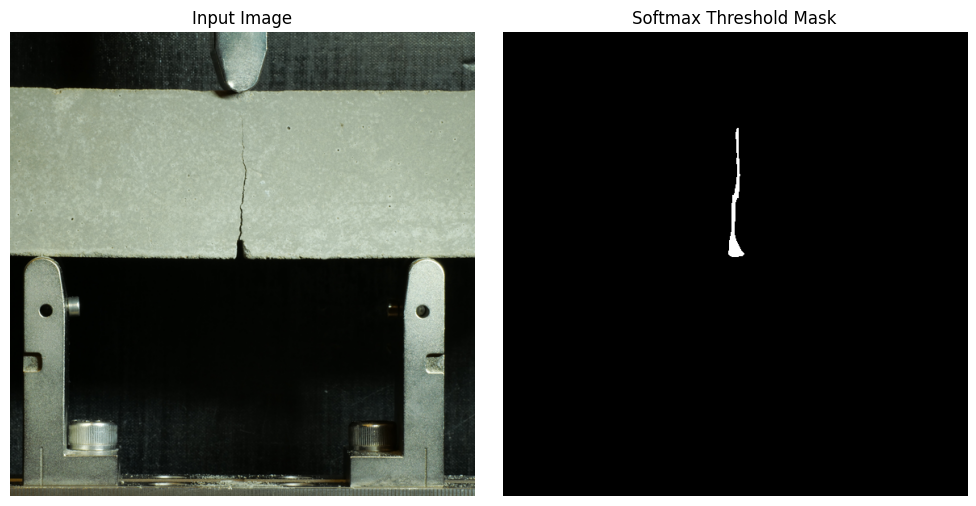

In [6]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# --------------------------
# Utility: Crop + Resize
# --------------------------
def crop_center_square_and_resize(img: Image.Image, size: int = 576) -> Image.Image:
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top  = (h - side) // 2
    sq   = img.crop((left, top, left + side, top + side))
    return sq.resize((size, size), Image.LANCZOS)

# --------------------------
# Load TFLite model
# --------------------------
# TFLITE_MODEL = "real_quantized_custom_fastscnn_v8.tflite"
# TFLITE_MODEL = "Epoch_770_quantized_custom_fastscnn.tflite"
# TFLITE_MODEL = "Epoch_0780_quantized_custom_fastscnn.tflite"
TFLITE_MODEL = "Epoch_1420_quantized_custom_fastscnn.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

inp_det = interpreter.get_input_details()[0]
out_det = interpreter.get_output_details()[0]

in_shape = inp_det["shape"]       # [1, 3, 576, 576]
out_shape = out_det["shape"]      # [1, 2, 576, 576]
in_dtype = inp_det["dtype"]
out_dtype = out_det["dtype"]
in_scale, in_zp = inp_det.get("quantization", (1.0, 0))
out_scale, out_zp = out_det.get("quantization", (1.0, 0))

print(f"✅ Input shape: {in_shape}, dtype: {in_dtype}, scale: {in_scale}, zp: {in_zp}")
print(f"✅ Output shape: {out_shape}, dtype: {out_dtype}, scale: {out_scale}, zp: {out_zp}")

# --------------------------
# Preprocess input image
# --------------------------
# IMG_PATH = "val_1.jpg"
# IMG_PATH = "IMG_4444.jpg"
IMG_PATH = "IMG_4365.jpg"
img = Image.open(IMG_PATH).convert("RGB")
img_proc = crop_center_square_and_resize(img, size=576)

# Normalize to ImageNet stats
arr = np.array(img_proc, dtype=np.float32) / 255.0
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 1, 3)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
arr = (arr - mean) / std  # shape: [H, W, 3]

# Rearrange to NCHW: [1, 3, H, W]
arr = arr.transpose(2, 0, 1)[np.newaxis, ...]

# Quantize input if needed
if in_dtype in (np.uint8, np.int8):
    arr = arr / in_scale + in_zp
    arr = np.clip(arr, np.iinfo(in_dtype).min, np.iinfo(in_dtype).max).astype(in_dtype)

# --------------------------
# Run inference
# --------------------------
interpreter.set_tensor(inp_det["index"], arr)
interpreter.invoke()
out_tensor = interpreter.get_tensor(out_det["index"])  # shape: [1, 2, H, W]

# Dequantize output if needed
out = out_tensor.astype(np.float32)
if out_dtype in (np.uint8, np.int8):
    out = (out - out_zp) * out_scale

# --------------------------
# Softmax + threshold → binary mask
# --------------------------
prob = tf.nn.softmax(out[0], axis=0)  # shape: [2, H, W]
mask = (prob[1] > 0.5).numpy().astype(np.uint8)  # class 1 = crack

# --------------------------
# Visualize
# --------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_proc)
ax1.set_title("Input Image")
ax1.axis("off")

ax2.imshow(mask, cmap="gray", vmin=0, vmax=1)
ax2.set_title("Softmax Threshold Mask")
ax2.axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_3522881/3450552614.py:13: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  alpha_img = Image.fromarray((mask * int(255 * alpha)).astype(np.uint8), mode="L")


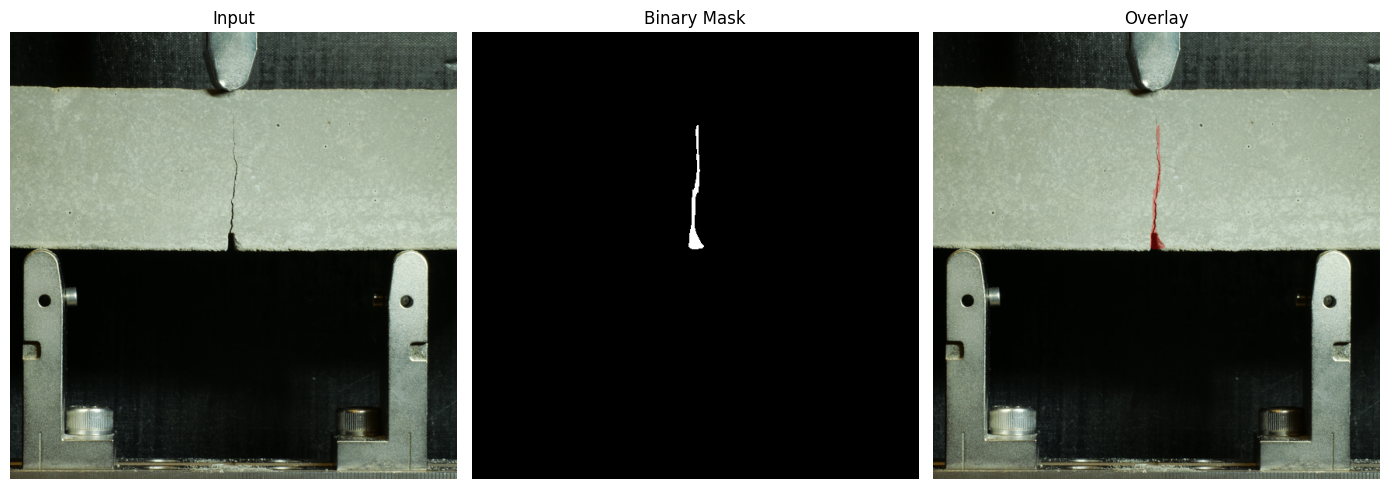

In [7]:
# --------------------------
# Visualize: input | mask | overlay
# --------------------------
alpha = 0.3  # transparency for crack overlay

# Ensure sizes match
h, w = mask.shape
assert img_proc.size == (w, h), f"Size mismatch: img={img_proc.size}, mask={(w,h)}"

# Build an RGBA overlay where A = alpha * mask
base_rgba = img_proc.convert("RGBA")
overlay_rgba = Image.new("RGBA", (w, h), (255, 0, 0, 0))  # red, fully transparent
alpha_img = Image.fromarray((mask * int(255 * alpha)).astype(np.uint8), mode="L")
overlay_rgba.putalpha(alpha_img)

# Composite
composited = Image.alpha_composite(base_rgba, overlay_rgba).convert("RGB")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(img_proc);              axes[0].set_title("Input");  axes[0].axis("off")
axes[1].imshow(mask, cmap="gray", vmin=0, vmax=1); axes[1].set_title("Binary Mask"); axes[1].axis("off")
axes[2].imshow(composited);            axes[2].set_title("Overlay"); axes[2].axis("off")
plt.tight_layout(); plt.show()


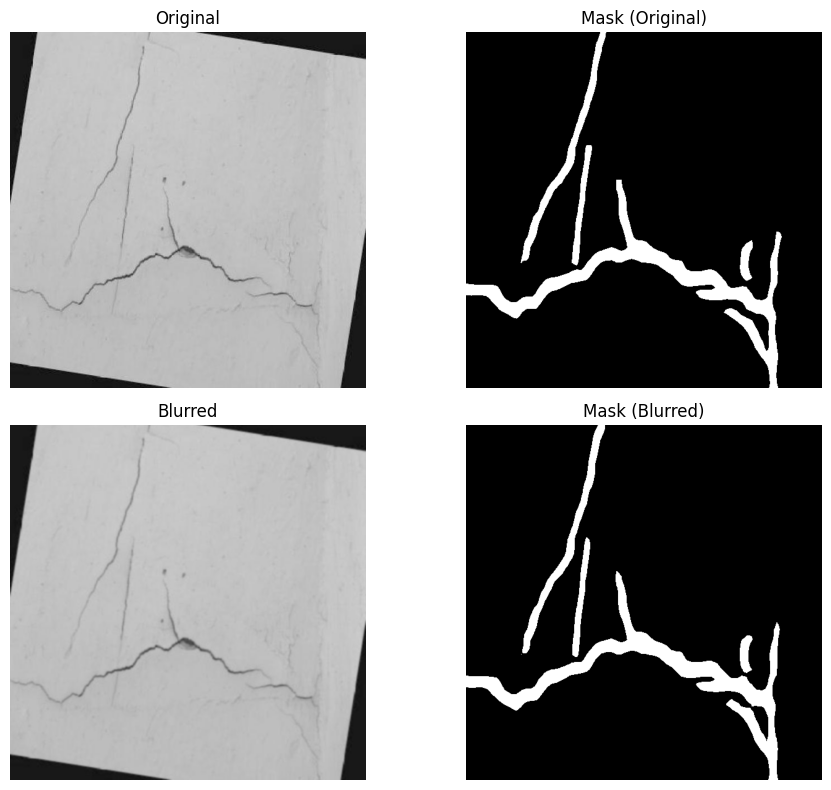

In [8]:
import numpy as np
from PIL import Image, ImageFilter
import tensorflow as tf
import matplotlib.pyplot as plt

# --------------------------
# Utility: Crop + Resize
# --------------------------
def crop_center_square_and_resize(img: Image.Image, size: int = 576) -> Image.Image:
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top  = (h - side) // 2
    sq   = img.crop((left, top, left + side, top + side))
    return sq.resize((size, size), Image.LANCZOS)

# --------------------------
# Load TFLite model
# --------------------------
TFLITE_MODEL = "Epoch_1420_quantized_custom_fastscnn.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()

inp_det = interpreter.get_input_details()[0]
out_det = interpreter.get_output_details()[0]

in_dtype = inp_det["dtype"]
out_dtype = out_det["dtype"]
in_scale, in_zp = inp_det.get("quantization", (1.0, 0))
out_scale, out_zp = out_det.get("quantization", (1.0, 0))

# --------------------------
# Preprocess & inference function
# --------------------------
def run_inference(img_pil):
    arr = np.array(img_pil, dtype=np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape(1, 1, 3)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    arr = (arr - mean) / std
    arr = arr.transpose(2, 0, 1)[np.newaxis, ...]
    if in_dtype in (np.uint8, np.int8):
        arr = arr / in_scale + in_zp
        arr = np.clip(arr, np.iinfo(in_dtype).min, np.iinfo(in_dtype).max).astype(in_dtype)

    interpreter.set_tensor(inp_det["index"], arr)
    interpreter.invoke()
    out_tensor = interpreter.get_tensor(out_det["index"]).astype(np.float32)
    if out_dtype in (np.uint8, np.int8):
        out_tensor = (out_tensor - out_zp) * out_scale
    prob = tf.nn.softmax(out_tensor[0], axis=0)
    mask = (prob[1] > 0.5).numpy().astype(np.uint8)
    return mask

# --------------------------
# Load original & blurred
# --------------------------
# IMG_PATH = "IMG_4365.jpg"
# IMG_PATH = "val_1.jpg"
IMG_PATH = "sample_new.jpg"
img = Image.open(IMG_PATH).convert("RGB")
img_proc = crop_center_square_and_resize(img, size=576)

# Create blurred version
img_blur = img_proc.filter(ImageFilter.GaussianBlur(radius=1))

# Run inference
mask_orig = run_inference(img_proc)
mask_blur = run_inference(img_blur)

# --------------------------
# Visualize
# --------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0,0].imshow(img_proc); axes[0,0].set_title("Original"); axes[0,0].axis("off")
axes[0,1].imshow(mask_orig, cmap="gray"); axes[0,1].set_title("Mask (Original)"); axes[0,1].axis("off")

axes[1,0].imshow(img_blur); axes[1,0].set_title("Blurred"); axes[1,0].axis("off")
axes[1,1].imshow(mask_blur, cmap="gray"); axes[1,1].set_title("Mask (Blurred)"); axes[1,1].axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_3522881/3011729785.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("best_fastscnn_epoch2140.pth", map_location="cpu")


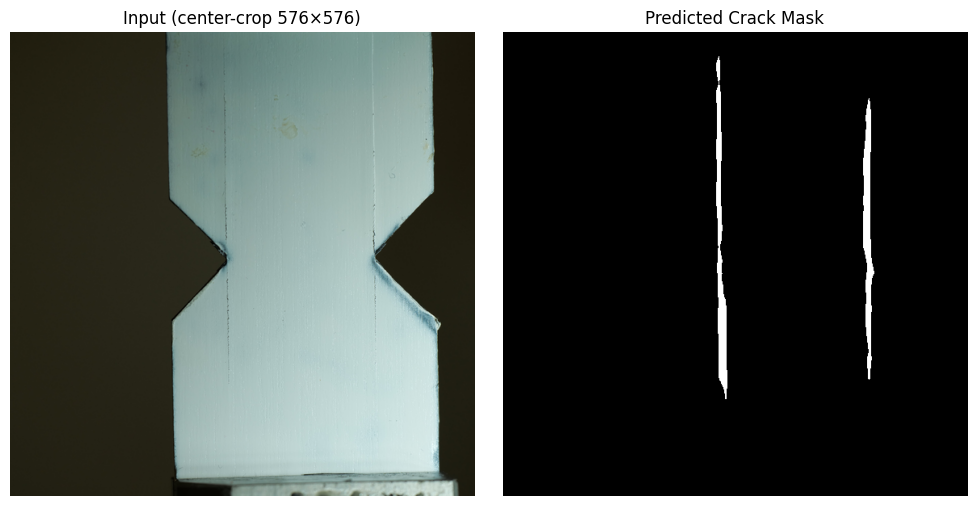

In [10]:
# inference_pytorch_fastscnn.py

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

from fast_scnn import FastSCNN

# --------------------------
# 0) Utility: Center-crop square & resize
# --------------------------
def crop_center_square_and_resize(img: Image.Image,
                                  size: int = 576,
                                  resample=Image.LANCZOS) -> Image.Image:
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top  = (h - side) // 2
    sq   = img.crop((left, top, left + side, top + side))
    return sq.resize((size, size), resample)

# --------------------------
# 1) Replace BatchNorm2d → GroupNorm
# (needed to match your finetuned checkpoint)
# --------------------------
def convert_bn_to_gn(module: nn.Module, num_groups: int = 8):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            gn = nn.GroupNorm(num_groups=num_groups,
                              num_channels=child.num_features,
                              affine=True)
            setattr(module, name, gn)
        else:
            convert_bn_to_gn(child, num_groups)

# --------------------------
# 2) Inference function
# --------------------------
def infer_pytorch(model: nn.Module,
                  image_path: str,
                  size: int = 576,
                  device: torch.device = torch.device("cpu")):
    # 2.1) Load & preprocess
    img = Image.open(image_path).convert("RGB")
    inp = crop_center_square_and_resize(img, size=size, resample=Image.LANCZOS)
    
    tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    x = tf(inp).unsqueeze(0).to(device)  # [1,3,H,W]
    
    # 2.2) Forward pass
    model.eval()
    with torch.no_grad():
        out = model(x)
        # model returns a tuple: (seg_logits, [aux_logits])
        if isinstance(out, (tuple, list)):
            out = out[0]
        # out: [1,2,H,W]
        mask = torch.argmax(out, dim=1).squeeze().cpu().numpy()  # [H,W]
    
    return inp, mask

# --------------------------
# 3) Main
# --------------------------
if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 3.1) Instantiate model and load checkpoint
    model = FastSCNN(num_classes=2, aux=False)
    # convert_bn_to_gn(model, num_groups=8)
    # ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")
    ckpt = torch.load("best_fastscnn_epoch2140.pth", map_location="cpu")

    # raw_ckpt = torch.load("best_val1_model_1000.pth", map_location="cpu")
    # ckpt = {k.replace("module.", ""): v for k, v in raw_ckpt.items()}
    model.load_state_dict(ckpt)
    model.to(DEVICE)
    
    # 3.2) Run inference on 3.jpg
    input_img, pred_mask = infer_pytorch(model, "3.jpg", size=576, device=DEVICE)
    
    # 3.3) Visualize
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(input_img)
    ax0.set_title("Input (center-crop 576×576)")
    ax0.axis("off")
    
    ax1.imshow(pred_mask, cmap="gray", vmin=0, vmax=1)
    ax1.set_title("Predicted Crack Mask")
    ax1.axis("off")
    
    plt.tight_layout()
    plt.show()
